In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import optuna

In [63]:
df = pd.read_excel('data_for_test.xlsx', index_col = 'Date'
                  )
df = df['Y']
df = df.dropna()

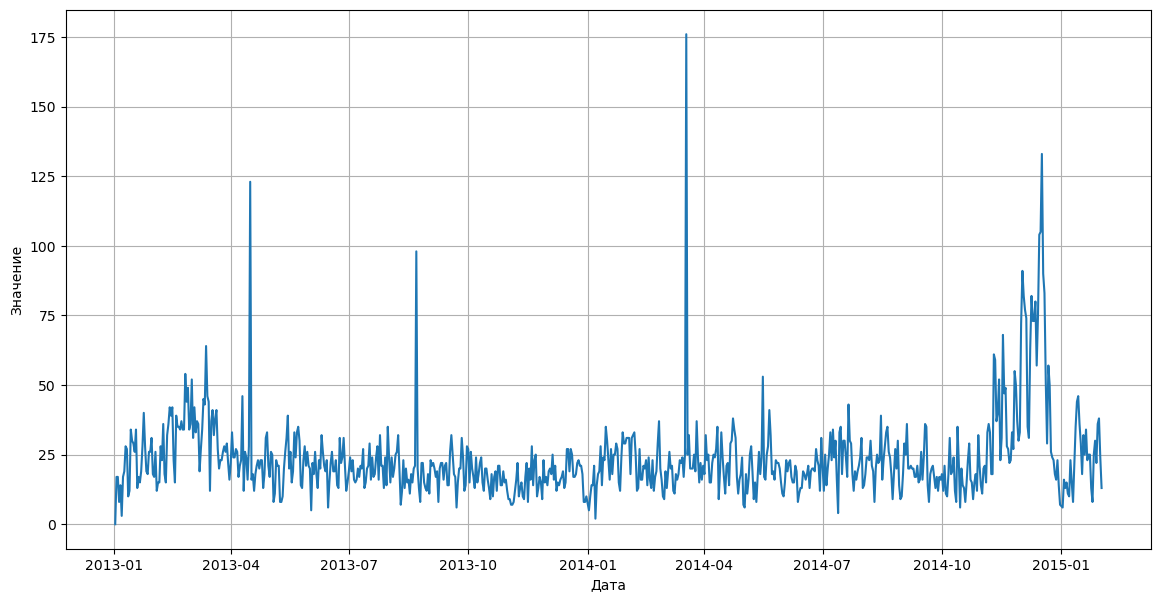

In [69]:
plt.figure(figsize=(14, 7))
plt.plot(df)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.grid(True)
plt.show()

# Сезонная декомпозиция

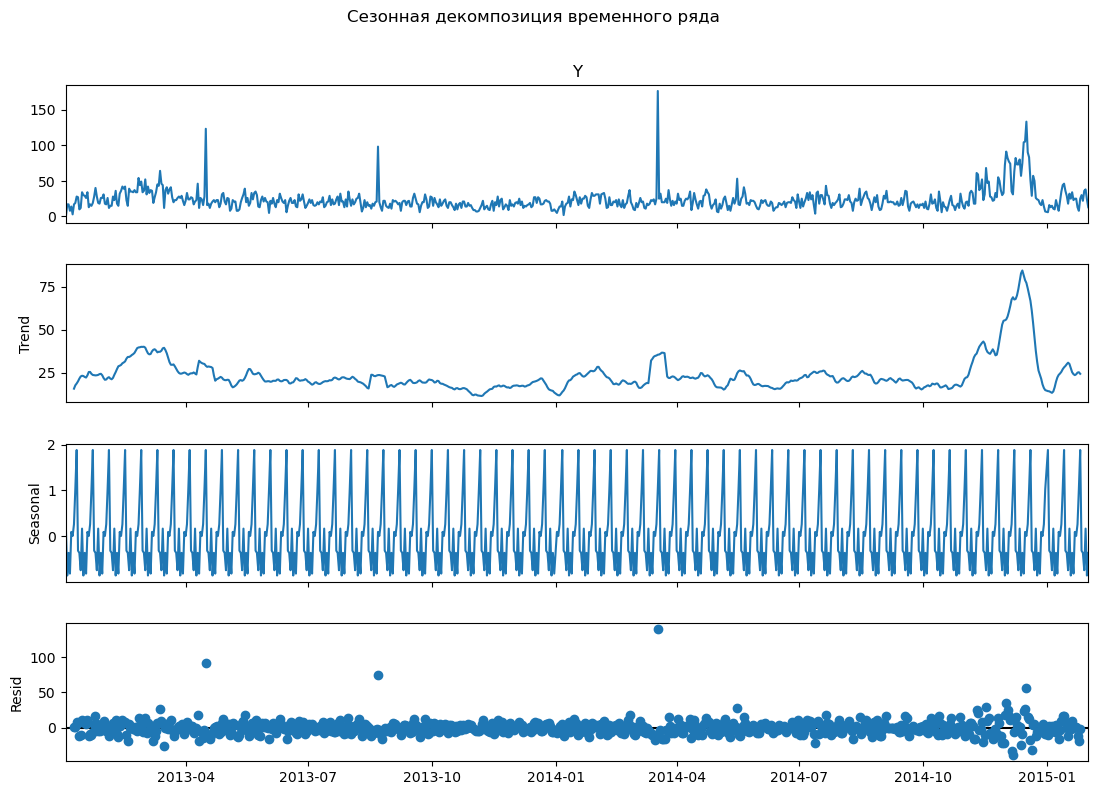

In [71]:
decomposition = seasonal_decompose(df, model='additive', period=12) # period=12 для месячных данных

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Сезонная декомпозиция временного ряда', y=1.02)
plt.show()

**Тренд:** Не наблюдается явного тренда   
**Сезонность:** Присутствует выраженная  сезонность с повторяющимися паттернами каждые 13 дней (2 недели)   
**Остатки (Residuals):** Остатки представляют собой случайный шум после удаления тренда и сезонности. Видны аномальные значения

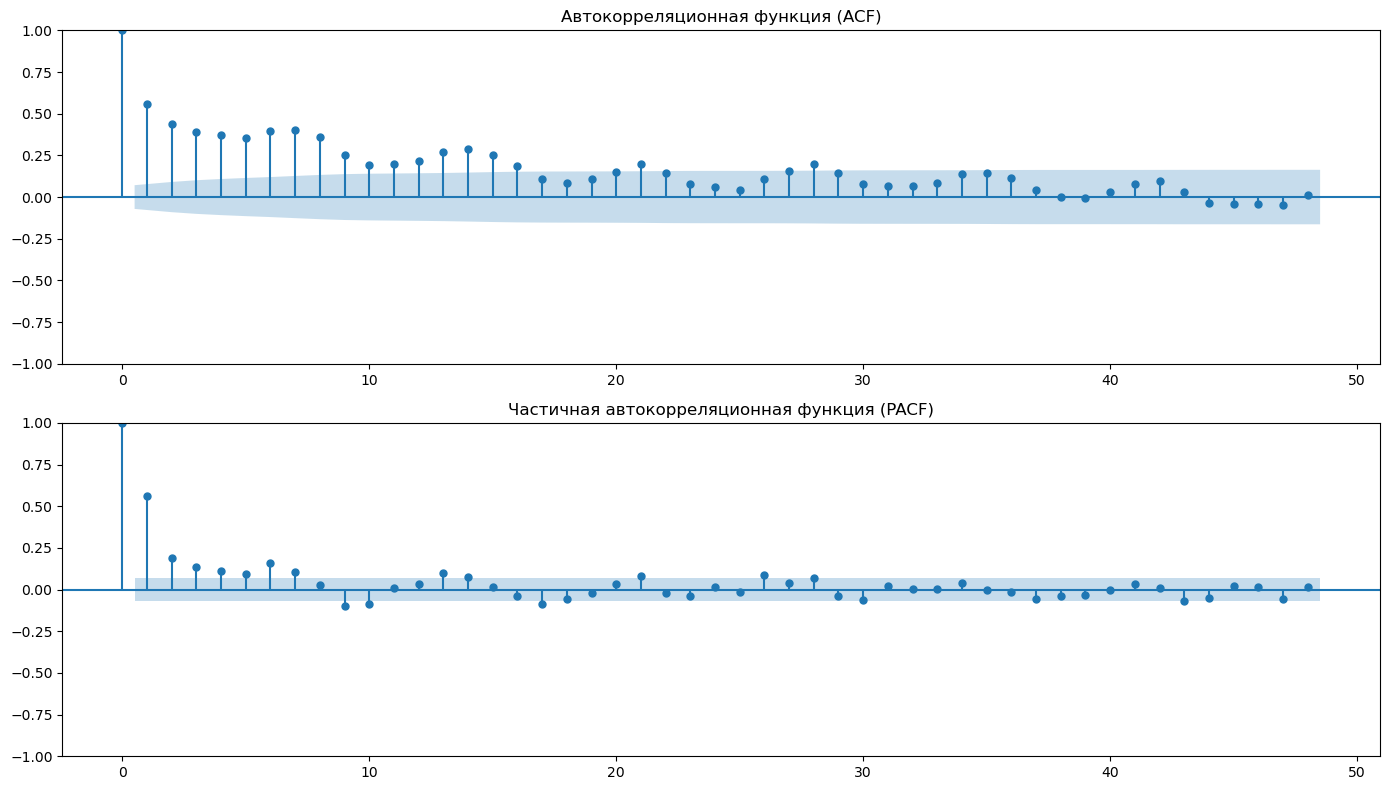

In [88]:
plt.figure(figsize=(14, 8))

plt.subplot(211)
plot_acf(df.dropna(), lags=48, ax=plt.gca(), title='Автокорреляционная функция (ACF)')
plt.subplot(212)
plot_pacf(df.dropna(), lags=48, ax=plt.gca(), title='Частичная автокорреляционная функция (PACF)')
plt.tight_layout()
plt.show()

ACF : Медленно затухает, возможно наличие тренда. Небольшие пики говорят о возможной сезонности.
PACF резко падает до незначимых значений после нескольких лагов, это может указывать на наличие компонента авторегрессии (AR=3 AR=4)     
Также имеются пики, что говорит о наличии сезонности

In [91]:
train_size = int(len(df) * 0.8)
train_data, test_data = df[0:train_size], df[train_size:]

print(f"Размер обучающей выборки: {len(train_data)}")
print(f"Размер тестовой выборки: {len(test_data)}")

Размер обучающей выборки: 607
Размер тестовой выборки: 152


In [199]:
# SARIMA модель
# Предварительный подбор параметров на основе анализа ACF/PACF
# (p, d, q) = (3, 1, 1) и (P, D, Q, S) = (3, 1, 1, 12)
sarima_model = SARIMAX(train_data,
                        order=(1, 1, 1),
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

sarima_results = sarima_model.fit(disp=False)
print("SARIMA Summary:")
print(sarima_results.summary())

# Прогноз SARIMA
sarima_forecast = sarima_results.predict(start=len(train_data), end=len(df)-1)

# Оценка адекватности модели (для обучающей выборки)
# Прогнозирование на обучающей выборке для оценки
sarima_train_forecast = sarima_results.predict(start=0, end=len(train_data)-1)
mse_train_sarima = mean_squared_error(train_data, sarima_train_forecast)
print(f"\nMSE на обучающей выборке (SARIMA): {mse_train_sarima:.2f}")

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


SARIMA Summary:
                                     SARIMAX Results                                      
Dep. Variable:                                  Y   No. Observations:                  607
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2245.221
Date:                            Mon, 02 Jun 2025   AIC                           4500.442
Time:                                    21:40:40   BIC                           4522.257
Sample:                                         0   HQIC                          4508.947
                                            - 607                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1374      0.030      4.587      0.000       0.079       0.196
ma.L1         -0.94

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Хольт-Уинтерс

In [191]:
holt_winters_model = ExponentialSmoothing(train_data,
                                          seasonal_periods=12,
                                          trend='add',
                                          seasonal='add',
                                          initialization_method="estimated").fit()

print("\nHolt-Winters Summary:")
print(holt_winters_model.summary())

# Прогноз Хольта-Уинтерса
holt_winters_forecast = holt_winters_model.predict(start=len(train_data), end=len(df)-1)

# Оценка адекватности модели (для обучающей выборки)
holt_winters_train_forecast = holt_winters_model.predict(start=0, end=len(train_data)-1)
mse_train_hw = mean_squared_error(train_data, holt_winters_train_forecast)
print(f"MSE на обучающей выборке (Хольт-Уинтерс): {mse_train_hw:.2f}")


Holt-Winters Summary:
                       ExponentialSmoothing Model Results                       
Dep. Variable:                        Y   No. Observations:                  607
Model:             ExponentialSmoothing   SSE                          75879.662
Optimized:                         True   AIC                           2962.824
Trend:                         Additive   BIC                           3033.360
Seasonal:                      Additive   AICC                          2963.987
Seasonal Periods:                    12   Date:                 Mon, 02 Jun 2025
Box-Cox:                          False   Time:                         21:39:59
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0886979                alpha                 True
sm

C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


# Сравнение

In [201]:
rmse_sarima = np.sqrt(mean_squared_error(test_data, sarima_forecast))
rmse_holt_winters = np.sqrt(mean_squared_error(test_data, holt_winters_forecast))

print(f"\nRMSE SARIMA на тестовой выборке: {rmse_sarima:.2f}")
print(f"RMSE Хольт-Уинтерс на тестовой выборке: {rmse_holt_winters:.2f}")

if rmse_sarima < rmse_holt_winters:
    print("\nМодель SARIMA показала лучшую эффективность на тестовой выборке.")
else:
    print("\nМодель Хольта-Уинтерса показала лучшую эффективность на тестовой выборке.")


RMSE SARIMA на тестовой выборке: 25.15
RMSE Хольт-Уинтерс на тестовой выборке: 25.00

Модель Хольта-Уинтерса показала лучшую эффективность на тестовой выборке.


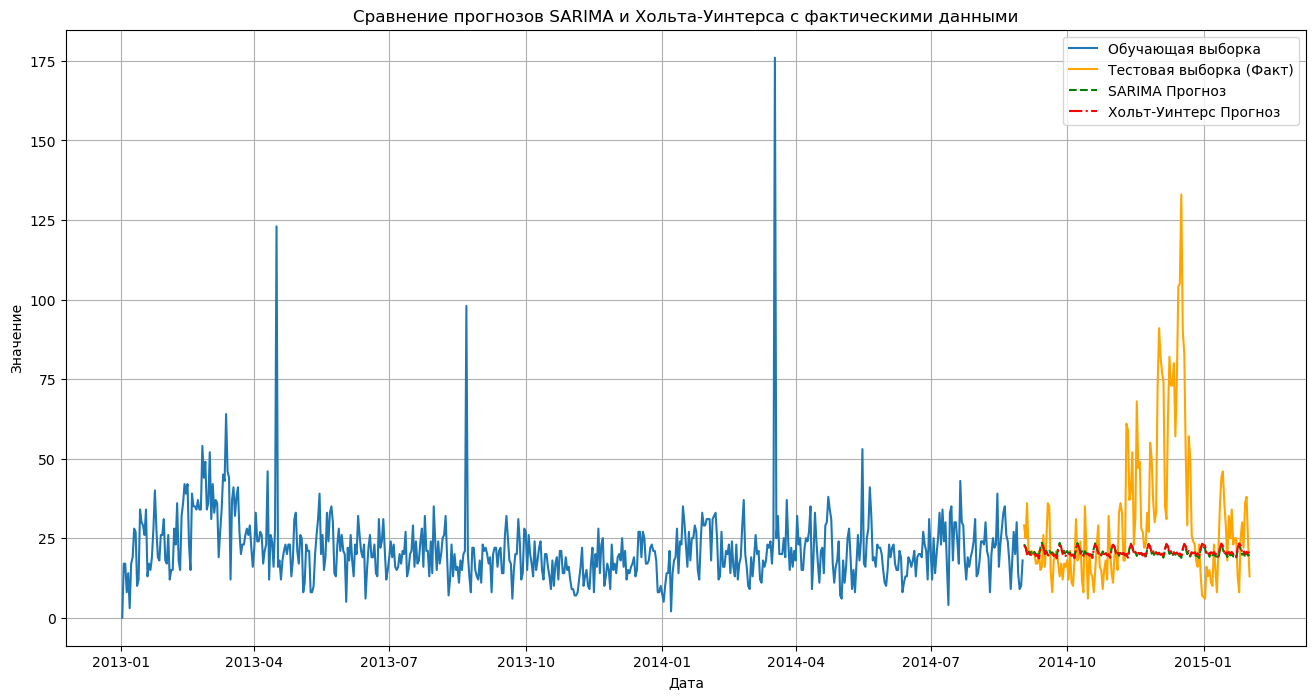

In [203]:
plt.figure(figsize=(16, 8))
plt.plot(train_data, label='Обучающая выборка')
plt.plot(test_data, label='Тестовая выборка (Факт)', color='orange')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Прогноз', color='green', linestyle='--')
plt.plot(test_data.index, holt_winters_forecast, label='Хольт-Уинтерс Прогноз', color='red', linestyle='-.')
plt.title('Сравнение прогнозов SARIMA и Хольта-Уинтерса с фактическими данными')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

По MSE Хольт-Уинтерс показал себя чуть лучше, хотя обе модели ужасно сильно занижают прогноз

# Тюнинг параметров

In [138]:
# 2. Определение целевой функции для Optuna
def objective(trial):
    # Предлагаем параметры для SARIMA
    # p, d, q - несезонные порядки
    # P, D, Q - сезонные порядки
    # S - сезонный период (фиксирован)

    p = trial.suggest_int('p', 0, 2)
    d = trial.suggest_int('d', 0, 1) # d обычно 0 или 1, редко 2
    q = trial.suggest_int('q', 0, 2)

    P = trial.suggest_int('P', 0, 1) # P обычно 0 или 1
    D = trial.suggest_int('D', 0, 1) # D обычно 0 или 1
    Q = trial.suggest_int('Q', 0, 1) # Q обычно 0 или 1
    S = trial.suggest_int('S', 1, 14)
    

    try:
        # Инициализация и обучение SARIMA модели
        model = SARIMAX(train_data,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, S),
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                        # Можно добавить другие параметры, например, trend='c' для константы
                       )
        model_fit = model.fit(disp=False) # disp=False подавляет вывод логов обучения

        # Прогноз на тестовой выборке
        forecast = model_fit.predict(start=len(train_data), end=len(df)-1)

        # Вычисляем RMSE
        rmse = np.sqrt(mean_squared_error(test_data, forecast))

        return rmse

    except Exception as e:
        # В случае ошибки (например, неконвергирующая модель) возвращаем очень большое значение
        # чтобы Optuna не считала эту комбинацию параметров хорошей
        return float('inf')

In [140]:
# 3. Запуск оптимизации Optuna
# n_trials - количество попыток (комбинаций параметров) Optuna попробует
# Если n_trials слишком мало, вы можете не найти оптимальные параметры.
# Увеличьте его, если у вас достаточно вычислительных ресурсов.
study = optuna.create_study(direction='minimize') # Мы хотим минимизировать RMSE
study.optimize(objective, n_trials=50) # Попробуем 50 комбинаций

# 4. Получение лучших параметров и соответствующего RMSE
best_params = study.best_params
best_rmse = study.best_value

print(f"\nЛучшие параметры SARIMA: {best_params}")
print(f"Лучший RMSE на тестовой выборке: {best_rmse:.2f}")

[I 2025-06-02 21:30:04,928] A new study created in memory with name: no-name-3509cd9f-4e9c-4b55-83a2-3384ee31feeb
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next versi


Лучшие параметры SARIMA: {'p': 0, 'd': 0, 'q': 0, 'P': 1, 'D': 1, 'Q': 1, 'S': 7}
Лучший RMSE на тестовой выборке: 23.97


In [205]:
final_sarima_model = SARIMAX(time_series, # Обучаем на всех данных для финального прогноза
                             order=(best_params['p'], best_params['d'], best_params['q']),
                             seasonal_order=(best_params['P'], best_params['D'], best_params['Q'], best_params['S']),
                             enforce_stationarity=False,
                             enforce_invertibility=False)

final_sarima_results = final_sarima_model.fit(disp=False)

sarima_forecast = final_sarima_results.predict(start=len(train_data), end=len(df)-1)

# Оценка адекватности модели (для обучающей выборки)
# Прогнозирование на обучающей выборке для оценки
sarima_train_forecast = final_sarima_results.predict(start=0, end=len(train_data)-1)
mse_train_sarima = mean_squared_error(train_data, sarima_train_forecast)
print(f"\nMSE на обучающей выборке (SARIMA): {mse_train_sarima:.2f}")


MSE на обучающей выборке (SARIMA): 226.34


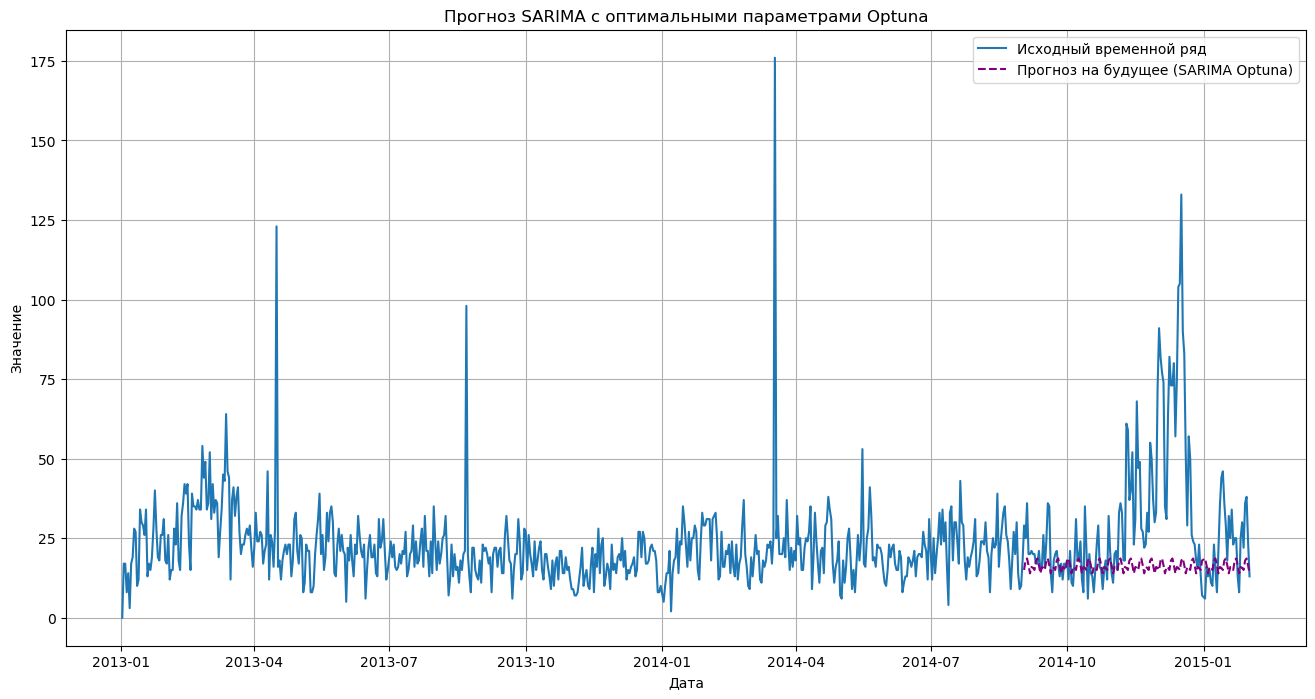

In [207]:
plt.figure(figsize=(16, 8))
plt.plot(df, label='Исходный временной ряд')
plt.plot(test_data.index, sarima_forecast, label='Прогноз на будущее (SARIMA Optuna)', color='purple', linestyle='--')
plt.title('Прогноз SARIMA с оптимальными параметрами Optuna')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

Эх, особо ничего не поменялось... Видимо, датасет не очень поддается прогнозированию именно подходами временных рядов